# Cut and Fill Volume Analysis from DTM

This notebook estimates **cut and fill volumes** using a Digital Terrain Model (DTM) and a boundary polygon that defines the work area.

The workflow computes the difference between the existing ground (DTM) and the **target design elevation** to identify where material must be **cut (removed)** or **filled (added)**.

---

## Core Formula and Concept

For each pixel in the DTM:

\[
D = E_{target} - E₍DTM₎
\]

Where:
- **D** = Elevation difference (m)
  - Positive → Fill (add material)
  - Negative → Cut (remove material)
- **E₍DTM₎** = Existing ground elevation
- **E₍target₎** = Target or design elevation

Each pixel represents a known ground area (based on raster resolution).  
Hence, total cut/fill volume is computed as:

\[
V = \sum (D \times * A₍pixel₎)
\]

Where:
- **V** = Total cut/fill volume (m³)
- **A₍pixel₎** = Pixel area = (resolution²)

This approach provides a pixel-by-pixel estimate of earthwork requirements.

---


Import Libraries

In [16]:
import rasterio
from rasterio.mask import mask
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 2 — Input Data
We load:
- **DTM raster** (existing surface)
- **Polygon shapefile** (boundary of project area)

In [17]:
dem_path = r"raw_data/Assignment_1_DTM.tif"
polygon_path = r"raw_data/Base_boundary.shp"

### Step 3 — Output Paths
Define file names for saving results.

In [18]:
out_final = "final_elevation.tif"
out_diff  = "diff_target_minus_dem.tif"
out_mask  = "polygon_mask.tif"
out_csv   = "cut_fill_volumes.csv"
plot_png  = "cut_fill_map.png"
placement = "cut_fill_depth_map.png"

### Step 4 — Define Target Elevations
the two design levels that were provided to us:
- Inside polygon → 331.26 m  
- Outside polygon → 329.50 m

In [19]:
level_inside = 331.26
level_outside = 329.5

### Step 5 — Clipping DTM to Polygon Extent for reduces compute time and avoid calculating for irrelevant area.

In [20]:
gdf = gpd.read_file(polygon_path)

with rasterio.open(dem_path) as src:
    print("DEM CRS:", src.crs, "NoData:", src.nodata)
    dem_clip_arr, transform = mask(src, gdf.geometry, crop=True)
    dem = dem_clip_arr[0].astype(float)
    profile = src.profile.copy()
    profile.update({
        "height": dem.shape[0],
        "width": dem.shape[1],
        "transform": transform
    })

DEM CRS: EPSG:32644 NoData: 0.0


### Step 6 — Replacing of nodata values with NaN for safe calculations.

In [21]:
with rasterio.open(dem_path) as src:
    nodata_val = src.nodata

if nodata_val is not None:
    dem[dem == nodata_val] = np.nan
else:
    dem[dem == 0] = np.nan

### Step 7 — just to verify if the clipped raster was generated correctly.

In [22]:
print("Clipped DEM shape:", dem.shape)
print("Total pixels:", dem.size,
      "Valid pixels:", np.sum(np.isfinite(dem)),
      "NaN pixels:", np.sum(np.isnan(dem)))
print("DEM valid min/max:", np.nanmin(dem), np.nanmax(dem))

Clipped DEM shape: (14672, 11304)
Total pixels: 165852288 Valid pixels: 114767216 NaN pixels: 51085072
DEM valid min/max: 322.7312927246094 339.4639892578125


### Step 8 — Creating a binary mask (1 inside polygon, 0 outside).

In [23]:
mask_arr = rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=dem.shape,
    transform=transform,
    fill=0,
    dtype=np.uint8
)

### Step 9 — Creating the Target Elevation Surface
Each pixel is assigned either the inside or outside elevation.

In [24]:
target = np.where(mask_arr == 1, level_inside, level_outside).astype(np.float32)
target[np.isnan(dem)] = np.nan

### Step 10 — Computing Elevation Difference
Calculate where and how much each pixel differs from the target.

In [25]:
diff = target - dem
valid_mask = np.isfinite(dem)

### Step 11 — Computing Cut/Fill Volumes
Multiply elevation differences by pixel area to get volume (m³).

In [26]:
cell_area = abs(transform[0] * transform[4])
print("Pixel area (m²):", cell_area)

diff_valid = np.where(valid_mask, diff, 0.0)
fill_pixels = diff_valid > 0
cut_pixels  = diff_valid < 0

fill_volume_total = np.sum(diff_valid[fill_pixels]) * cell_area
cut_volume_total  = np.sum(-diff_valid[cut_pixels]) * cell_area

inside_mask = (mask_arr == 1) & valid_mask
outside_mask = (mask_arr == 0) & valid_mask

fill_inside = np.sum(np.maximum(diff, 0)[inside_mask]) * cell_area
cut_inside  = np.sum(-np.minimum(diff, 0)[inside_mask]) * cell_area
fill_outside = np.sum(np.maximum(diff, 0)[outside_mask]) * cell_area
cut_outside  = np.sum(-np.minimum(diff, 0)[outside_mask]) * cell_area

print(f"Fill total (m³): {fill_volume_total:,.2f}")
print(f"Cut  total (m³): {cut_volume_total:,.2f}")
print(f"Net  (m³): {fill_volume_total - cut_volume_total:,.2f}")

Pixel area (m²): 0.003754294747289777
Fill total (m³): 351,761.50
Cut  total (m³): 1,037,300.95
Net  (m³): -685,539.45


### Step 12 — Save Outputs
Store all key rasters and summary CSV.

In [27]:
out_profile = profile.copy()
out_profile.update(dtype=rasterio.float32, count=1, nodata=np.float32(0))

# Target raster
target_write = np.where(np.isfinite(target), target, out_profile["nodata"]).astype(np.float32)
with rasterio.open(out_final, "w", **out_profile) as dst:
    dst.write(target_write, 1)

# Difference raster
diff_write = np.where(np.isfinite(diff), diff, out_profile["nodata"]).astype(np.float32)
with rasterio.open(out_diff, "w", **out_profile) as dst:
    dst.write(diff_write, 1)

# Polygon mask
mask_profile = profile.copy()
mask_profile.update(dtype=rasterio.uint8, count=1, nodata=0)
with rasterio.open(out_mask, "w", **mask_profile) as dst:
    dst.write(mask_arr.astype(rasterio.uint8), 1)

# Volume summary CSV
df = pd.DataFrame({
    "region": ["inside_polygon", "outside_polygon", "total"],
    "fill_m3": [fill_inside, fill_outside, fill_volume_total],
    "cut_m3": [cut_inside, cut_outside, cut_volume_total],
    "net_m3": [fill_inside - cut_inside, fill_outside - cut_outside, fill_volume_total - cut_volume_total]
})
df.to_csv(out_csv, index=False)
print("Saved:", out_final, out_diff, out_mask, out_csv)


Saved: final_elevation.tif diff_target_minus_dem.tif polygon_mask.tif cut_fill_volumes.csv


### Step 13 — Visualize Cut/Fill Depth Map
Color-coded difference map:
- Blue → Cut areas (negative)
- Red → Fill areas (positive)

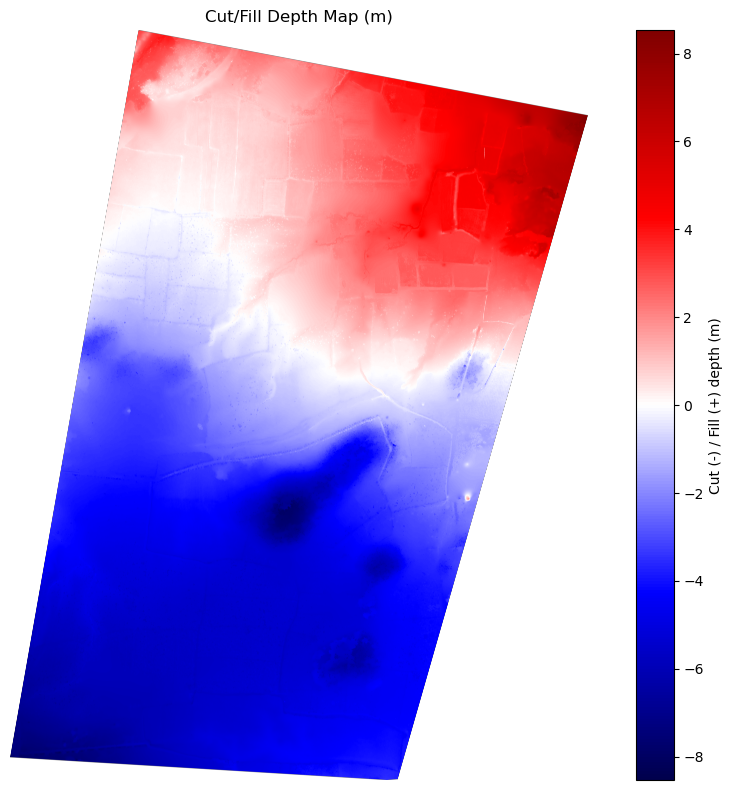

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
diff_disp = np.where(np.isnan(diff), np.nan, diff)
cmap = plt.cm.seismic
norm = plt.Normalize(vmin=-np.nanmax(abs(diff_disp)), vmax=np.nanmax(abs(diff_disp)))
im = ax.imshow(diff_disp, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax, label="Cut (-) / Fill (+) depth (m)")
ax.set_title("Cut/Fill Depth Map (m)")
ax.axis("off")
plt.tight_layout()
plt.savefig(placement, dpi=200)
plt.show()

### Step 14 — Visualize Clipped DTM
Reference visualization of the existing ground surface.

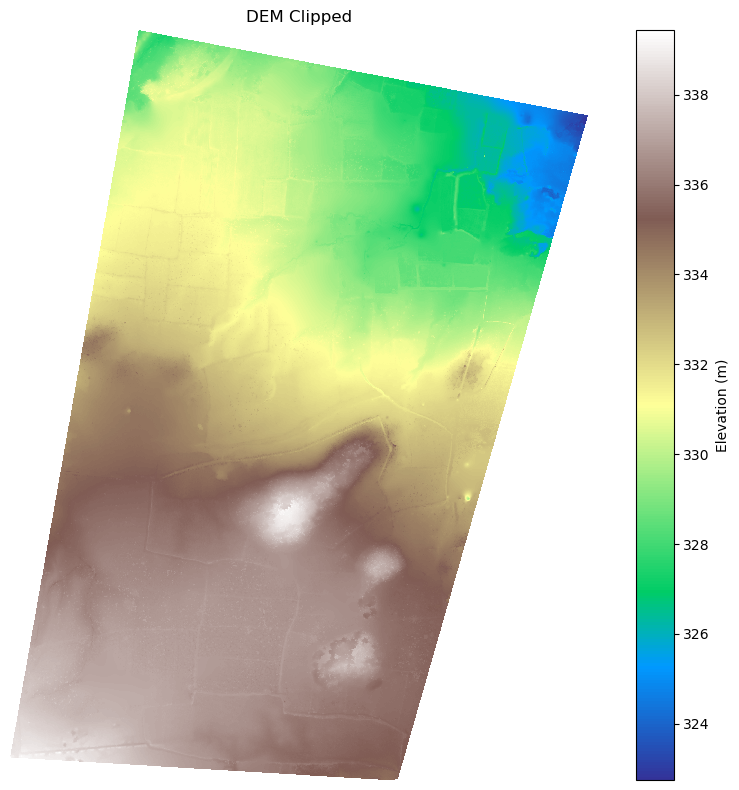

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
c = ax.imshow(dem[::4, ::4], cmap="terrain", interpolation="nearest")
fig.colorbar(c, ax=ax, label="Elevation (m)")
ax.set_title("DEM Clipped")
ax.axis("off")
plt.tight_layout()
plt.savefig(plot_png, dpi=200)
plt.show()

## Step 15 — Interpretation of Results

The `cut_fill_volumes.csv` file summarizes the total cut, fill, and net balance.

| Region | Fill (m³) | Cut (m³) | Net (m³) |
|---------|-----------|----------|-----------|
| Inside Polygon | Material added (fill) | Material removed (cut) | Net balance |
| Outside Polygon | Reference area (usually zero) |  |  |
| Total | Combined across study area |  |  |

### How to Read:
- **Positive Net Volume →** More fill required (material to import).  
- **Negative Net Volume →** More cut required (material to remove).  
- **Zero Net Volume →** Balanced (ideal scenario).  

Blue zones in the depth map mark **cuts**, red zones mark **fills**, and the magnitude indicates the vertical difference (in meters).

---

### Conclusion
This method provides a transparent and reproducible workflow for **terrain modification planning**.  
By combining raster-based elevation data and polygon boundaries, it precisely quantifies material movement requirements for construction, road design, or land grading projects.
